# WannierBerri advanced tutorial - Spin Hall conductivity

author: Jae-Mo Lihm (jaemo.lihm@gmail.com) and Minsu Ghim (minsu.ghim.physics@gmail.com)

In this tutorial, we calculate the spin Berry curvature and the spin Hall conductivity of bcc Platinum. We compare the two methods for calculating the spin velocity matrix, which we call the "Qiao" method [1] and the "Ryoo" method [2].

[1] [J. Qiao et al, Phys. Rev. B 98, 214402 (2018)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.214402) <br>
[2] [J. H. Ryoo et al, Phys. Rev. B 99, 235113 (2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.235113)

Both methods use the Kubo formula to calculate spin Hall conductivity under time-reversal symmetry:

\begin{equation}
\sigma^{{\rm SHC}, \gamma}_{\alpha\beta} = \frac{-e\hbar}{N_k V_c}\sum_{\bf k}\sum_{n,m}\left(f_{n{\bf k}}-f_{m{\bf k}}\right)\frac{\textrm{Im}\left[\langle\psi_{n{\bf k}}\vert \frac{1}{2}\{ s^{\gamma}, v_\alpha \} \vert\psi_{m{\bf k}}\rangle\langle\psi_{m{\bf k}}\vert v_\beta\vert\psi_{n{\bf k}}\rangle\right]}{(\varepsilon_{n{\bf k}}-\varepsilon_{m{\bf k}})^2-(\hbar\omega+i\eta)^2}\,,
\label{eq:shc}\tag{1}
\end{equation}

where $\alpha$, $\beta$, $\gamma$ are respectively the direction of spin current, applied electric field, and spin polarisation.

The "Ryoo" method requires `.chk`, `.eig`, `.mmn`, `.spn`, `.sHu`, and `.sIu` files to calculate the spin velocity matrix in (\ref{eq:shc}), $\langle\psi_{n{\bf k}}\vert \frac{1}{2}\{ s^{\gamma}, v_\alpha \} \vert\psi_{m{\bf k}}\rangle$,from pw2wannier90.x,
while the "Qiao" method does not use the last two files, and instead applies an approximation $\mathbf{1}=\sum_{l\in \it{ab\,initio}} \vert u_{l{\bf q}}\rangle\langle u_{l{\bf q}}\vert$.
The `sHu` and `sIu` files are calculated by setting `write_sHu = .true.` and `write_sIu = .true.` to the `pw2wannier90.x` input file: see `data_Pt/pw2wan.in`.

In [1]:
# Preliminary (Do only once)
%load_ext autoreload
%autoreload 2

# Set environment variables - not mandatory but recommended
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['MKL_NUM_THREADS'] = '1'


import wannierberri as wberri
import numpy as np
import scipy
import matplotlib.pyplot as plt

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

parallel = wberri.Parallel(num_cpus=4, progress_step_percent=10)
wberri.__version__

2023-09-27 18:38:39,350	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 


'0.14.1ss'

### Model, band structure

We load the system from a Wannier90 output. Note the arguments `SHCryoo=True` and `SHCqiao=True` which are required to compute spin Hall conductivity using the Ryoo and Qiao methods, respectively.

We set symmetry using the `set_symmetry_from_structure` method, which calls spglib to automatically determine the symmetry of the system.

<!-- We also symmetrize the system. See `data_Pt/Pt.win` file and check that the initial projections are correct. For details, refer to the symmetrization tutorial. -->

In [2]:
system = wberri.System_w90("data_Pt_proj//Pt", berry=True, SHCryoo=True, SHCqiao=True)
system_simple = wberri.System_w90("data_Pt_proj//Pt", berry=True)
system_simple.set_spin_from_code("qe")
system.set_structure([[0., 0., 0.]], ["Pt"])
system.set_symmetry_from_structure()
system_simple.set_structure([[0., 0., 0.]], ["Pt"])
system_simple.set_symmetry_from_structure()

efermi = 18.1605

using fortio to read
Reading restart information from file data_Pt_proj//Pt.chk :
Time to read .chk : 0.13997507095336914
Time for MMN.__init__() : 0.31647658348083496 , read : 0.3084907531738281 , headstring 0.007985830307006836
----------
 SPN  
---------

using fortio to read
reading data_Pt_proj//Pt.spn : Created on 13May2022 at 15:23:23                            
----------
 SPN OK  
---------

----------
  sIu   
---------
using fortio to read
reading data_Pt_proj//Pt.sIu : <Created on 13May2022 at 15:23:23>
----------
 sIu OK  
---------

----------
  sHu   
---------
using fortio to read
reading data_Pt_proj//Pt.sHu : <Created on 13May2022 at 15:23:23>
----------
 sHu OK  
---------

time for FFT_q_to_R : 0.6484673023223877 s
using ws_distance
irvec_new_all shape (93,)
using ws_dist for Ham
using ws_dist for AA
using ws_dist for SS
using ws_dist for SR
using ws_dist for SH
using ws_dist for SHR
using ws_dist for SA
using ws_dist for SHA
Number of wannier functions: 18
Number o

In [3]:
path = wberri.Path(
    system,
    k_nodes=[
        [0.25, 0.75, 0.50], # W
        [0.50, 0.50, 0.50], # L
        [0.00, 0.00, 0.00], # Gamma
        [0.50, 0.00, 0.50], # X
        [0.50, 0.25, 0.75], # W
        [0.00, 0.00, 0.00], # Gamma
    ],
    labels=["W", "L", "$\Gamma$", "X", "W", "$\Gamma$"],
    length=300,
)

from wannierberri import calculators as calc
calculators = {}
calculators["tabulate"] = calc.TabulatorAll(
    {"Energy": calc.tabulate.Energy()},
    ibands=np.arange(system.num_wann),
    mode="path",
)

path_result = wberri.run(
    system,
    grid=path,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f65245c73a0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 322 points and labels {0: 'W', 54: 'L', 120: '$\\Gamma$', 197: 'X', 235: 'W', 321: '$\\Gamma$'}
generating K_list
Done 
Done, sum of weights:322.0
symgroup : None
processing 322 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing    322 K-points on   4 processes:     3.4594 ; per K-point          0.0107 ; proc-sec per K-point          0.0430
time1 =  0.021153926849365234
Totally processed 322 K-points 


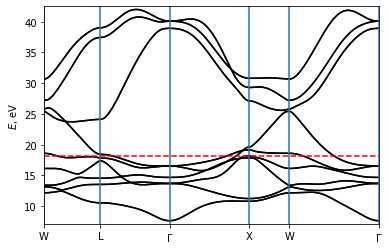

In [4]:
fig = path_result.results["tabulate"].plot_path_fat(path, close_fig=False, show_fig=False)

ax = fig.get_axes()[0]
ax.axhline(efermi, c="r", ls="--")
plt.show(fig)

## Static spin Hall conductivity

We calculate the static (i.e. DC) spin Hall conductivity. We fix $\omega$ to 0 and scan the Fermi energy.

In [18]:
from wannierberri import calculators as calc

efermi_list = np.linspace(efermi - 1.0, efermi + 1.0, 101, True)

kwargs = dict(
    Efermi=efermi_list,
    omega=np.array([0.]),
    smr_fixed_width = 0.1, # Smearing for frequency in eV
    kBT = 0.026, # Smearing for Fermi level (Fermi-Dirac factor) in eV (not Kelvin)
)

calculators_simple = dict(
    SHC_simple = calc.dynamic.SHC(SHC_type="simple", **kwargs),
    SHC_simple_full = calc.dynamic.SHC(SHC_type="simple", kwargs_formula={"external_terms":True}, **kwargs),
    SHC_simple_int = calc.dynamic.SHC(SHC_type="simple", kwargs_formula={"external_terms":False}, **kwargs),
    )

calculators_full = dict(
    SHC_ryoo = calc.dynamic.SHC(SHC_type="ryoo", **kwargs),
    SHC_qiao = calc.dynamic.SHC(SHC_type="qiao", **kwargs),
)
calculators_full.update(calculators_simple)

calculator not described

calculator not described

calculator not described

calculator not described

calculator not described



In [19]:

nk = 30
grid = wberri.Grid(system, NK=nk)
result_simple = wberri.run(
    system_simple,
    grid=grid,
    calculators=calculators_simple,
    parallel=parallel,
    print_Kpoints = False,
)

result_full = wberri.run(
    system,
    grid=grid,
    calculators=calculators_full,
    parallel=parallel,
    print_Kpoints = False,
)

determining grids from NK=30 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]
Grid is regular
The set of k points is a Grid() with NKdiv=[6 6 6], NKFFT=[5 5 5], NKtot=[30 30 30]
generating K_list
Done in 0.0027806758880615234 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.10213184356689453 s 
Done in 0.10216426849365234 s 
K_list contains 16 Irreducible points(7.41%) out of initial 6x6x6=216 grid
Done, sum of weights:0.9999999999999997
symgroup : Real_lattice:
[[-1.956  0.     1.956]
 [ 0.     1.956  1.956]
 [-1.956  1.956  0.   ]]
 Recip. Lattice:
 [[-1.6061 -1.6061  1.6061]
 [ 1.6061  1.6061  1.6061]
 [-1.6061  1.6061 -1.6061]]
 size:96
Operations:
0:
rotation:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]] , TR: False , I: False
1:
rotation:
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]] , TR: False , I: True
2:
rotation:
[[

The SHC data has 5 indices:
1. The Fermi level index,
2. The frequency index,
3. The spin current direction index,
4. The electric field direction index, and
5. The spin polarization index.

In [8]:
print("result.results[\"SHC_ryoo\"].data.shape = ", result.results["SHC_ryoo"].data.shape)

result.results["SHC_ryoo"].data.shape =  (101, 1, 3, 3, 3)


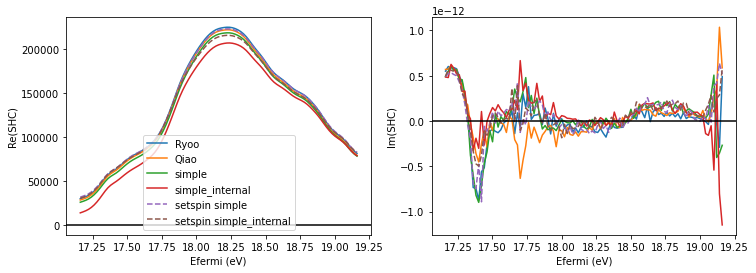

In [32]:
result=result_full
shc_ryoo = result.results["SHC_ryoo"].data[:, 0, 0, 1, 2]
shc_qiao = result.results["SHC_qiao"].data[:, 0, 0, 1, 2]
shc_simple = result.results["SHC_simple"].data[:, 0, 0, 1, 2]
shc_simple_int = result.results["SHC_simple_int"].data[:, 0, 0, 1, 2]
result=result_simple
shc_setspin_simple = result.results["SHC_simple"].data[:, 0, 0, 1, 2]
shc_setspin_simple_int = result.results["SHC_simple_int"].data[:, 0, 0, 1, 2]



fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(efermi_list, shc_ryoo.real, label="Ryoo")
axes[0].plot(efermi_list, shc_qiao.real, label="Qiao")
axes[0].plot(efermi_list, shc_simple.real, label="simple")
axes[0].plot(efermi_list, shc_simple_int.real, label="simple_internal")
axes[0].plot(efermi_list, shc_setspin_simple.real, "--", label="setspin simple")
axes[0].plot(efermi_list, shc_setspin_simple_int.real, "--", label="setspin simple_internal")
axes[1].plot(efermi_list, shc_ryoo.imag)
axes[1].plot(efermi_list, shc_qiao.imag)
axes[1].plot(efermi_list, shc_simple.imag)
axes[1].plot(efermi_list, shc_simple_int.imag)
axes[1].plot(efermi_list, shc_setspin_simple.imag, "--")
axes[1].plot(efermi_list, shc_setspin_simple_int.imag, "--")
for ax in axes:
    ax.set_xlabel("Efermi (eV)")
    ax.axhline(0, c="k")
axes[0].set_ylabel("Re(SHC)")
axes[1].set_ylabel("Im(SHC)")
axes[0].legend()
plt.show()